### Preparing the data with pandas library ###

In [1]:
import sqlite3
import pandas as pd
import csv
import json
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## As we see in the CSV file, the sales data was without column names.Hence adding them #
df_sales=pd.read_csv('YearlySales2010-2019.csv',usecols=[0,1,2,3,4,5],header=None,names=["Name", "Year", "Area", "City" ,"Open_Year", "Sales"])

In [3]:
df_sales.head()

,Name,Year,Area,City,Open_Year,Sales
0,London21,2010,275,London,1981,717144
1,London21,2011,275,London,1981,746104
2,London21,2012,275,London,1981,843560
3,London21,2013,275,London,1981,892459
4,London21,2014,275,London,1981,782720


In [4]:
# Cleaning the marketing data csv, specifically the location and the year columns and loading in a dataframe#
df_marketing= pd.read_csv('MarketingSpend2010-2019.csv')

In [5]:
df_marketing['Year'], df_marketing['MarketingSpend'] = df_marketing['MarketingSpend'].str.split(',', 1).str

C:\Users\charl\AppData\Local\Temp/ipykernel_4940/4005077137.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_marketing['Year'], df_marketing['MarketingSpend'] = df_marketing['MarketingSpend'].str.split(',', 1).str


In [6]:
# Removing the unnecessary punctuations from the data#
df_marketing['MarketingSpend']=df_marketing['MarketingSpend'].apply(lambda x:x.strip(')'))
df_marketing['MarketingSpend']=df_marketing['MarketingSpend'].astype(int)
df_marketing['Year']=df_marketing['Year'].apply(lambda x:x.strip('('))

In [7]:
# Removing Punctuations and reordering the column #
df_marketing['City'], df_marketing['Pcode'] = df_marketing['Location'].str.split(';', 1).str
df_marketing = df_marketing.drop(labels="City", axis=1)
df_marketing=df_marketing[["Name", "Year","Pcode", "MarketingSpend"]]

C:\Users\charl\AppData\Local\Temp/ipykernel_4940/3365094531.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_marketing['City'], df_marketing['Pcode'] = df_marketing['Location'].str.split(';', 1).str


In [8]:
df_sales.head()

,Name,Year,Area,City,Open_Year,Sales
0,London21,2010,275,London,1981,717144
1,London21,2011,275,London,1981,746104
2,London21,2012,275,London,1981,843560
3,London21,2013,275,London,1981,892459
4,London21,2014,275,London,1981,782720


In [9]:
df_marketing.head()

,Name,Year,Pcode,MarketingSpend
0,London21,2010-2011,NE7 3VL,85792
1,London21,2012-2013,NE7 3VL,74479
2,London21,2014-2015,NE7 3VL,85506
3,London21,2016-2017,NE7 3VL,87320
4,London21,2018-2019,NE7 3VL,73292


### Soln -1 a- Creating a normalised SQLite Data Base ###

In [10]:
# Opening a database by the name stores#
conn=sqlite3.connect('Stores.db')
cursor=conn.cursor()

In [11]:
# Creating a table 'sales' directly from the CSV, will act as a base table#
cursor.execute("CREATE TABLE sales(Name VARCHAR(24),Year INTEGER,Area INTEGER, City VARCHAR(24),Open_year INTEGER,Sales INTEGER)")


In [12]:
conn.commit()

In [13]:
# Creating a table 'marketing' directly as per csv and will act as a base table#
cursor.execute("CREATE TABLE marketing(Name VARCHAR(24),Year INTEGER,Pcode VARCHAR(24),MarketingSpend INTEGER)")

In [14]:
conn.commit()

In [15]:
# Converting the sales dataframe to a table in sqlite3#
df_sales.to_sql("sales", conn, if_exists="append",index=False)

In [16]:
conn.commit()

In [17]:
# Converting the marketing dataframe to a table in sqlite3#
df_marketing.to_sql("marketing", conn, if_exists="append",index=False)

In [18]:
conn.commit()

In [19]:
# Creating a table where store information is stored#
cursor.execute("CREATE TABLE store_info(Name VARCHAR(24) PRIMARY KEY,Area INTEGER, City VARCHAR(24),Open_year INTEGER)")


In [20]:
conn.commit()

In [21]:
# Inserting values into the store_info table from the above base tables#
cursor.execute("INSERT INTO store_info (Name,Area,City,Open_year) SELECT DISTINCT Name,Area,City,Open_year FROM sales")

In [22]:
conn.commit()

In [23]:
# Creating a table where sales information for various stores is stored#
cursor.execute("CREATE TABLE sales_info(Name VARCHAR(24), Year INTEGER, Sales INTEGER, PRIMARY KEY(Name,Year), FOREIGN KEY(Name) REFERENCES store_info(Name))")

In [24]:
conn.commit()

In [25]:
# Inserting values into the sales_info table from base tables#
cursor.execute("INSERT INTO sales_info (Name,Year,Sales) SELECT Name,Year,Sales FROM Sales")

In [26]:
conn.commit()

In [27]:
# Creating a table where marketing information for various stores is stored# 
cursor.execute("CREATE TABLE marketing_info(Name VARCHAR(24), Year VARCHAR(24), MarketingSpend INTEGER,PRIMARY KEY(Name,Year),FOREIGN KEY(Name) REFERENCES store_info(Name))")

In [28]:
conn.commit()

In [29]:
# Inserting values into the marketing_info table from base tables#
cursor.execute('INSERT INTO marketing_info (Name,Year,Marketingspend) SELECT Name,Year,Marketingspend FROM marketing')

In [30]:
conn.commit()

In [31]:
# Creating a temporary table which will serve as a base table#
cursor.execute("CREATE TABLE m_trial(Name VARCHAR(24), Year VARCHAR(24),Pcode VARCHAR(24), MarketingSpend INTEGER,PRIMARY KEY(Name,Year),FOREIGN KEY(Name) REFERENCES store_info(Name))")

In [32]:
conn.commit()

In [33]:
# The location column is an addition in this table when compared to the marketing_info table#
cursor.execute('INSERT INTO m_trial (Name,Year,Pcode,Marketingspend) SELECT Name,Year,Pcode,Marketingspend FROM marketing')

In [34]:
conn.commit()

In [35]:
# Creating a table containing all information from store_info and location from m_trial#
cursor.execute('CREATE TABLE store_data AS select distinct a.*,b.pcode from store_info a left join m_trial b on a.name=b.name')


In [36]:
conn.commit()

In [37]:
# Deleting all base tables, after extracting and arranging all information in other tables #
cursor.execute("DROP TABLE IF EXISTS m_trial")
cursor.execute("DROP TABLE IF EXISTS store_info")
cursor.execute("DROP TABLE IF EXISTS sales")
cursor.execute("DROP TABLE IF EXISTS marketing")

In [38]:
conn.commit()

### Solution 1-b- Creating a store_size column in a table and populating it with the    right description ###

In [39]:
# As per 1-b Creating a new column 'store_size' in the table 'store_data'#
cursor.execute('ALTER TABLE store_data ADD COLUMN store_size VARCHAR(24)')

In [40]:
# Populating the store_size column with the desired descriptions#
cursor.execute('''UPDATE store_data SET store_size = 'Small' WHERE Area < 1000''')
cursor.execute('''UPDATE store_data SET store_size = 'Medium' WHERE Area >= 1000 and Area<=4000''') 
cursor.execute('''UPDATE store_data SET store_size = 'Large' WHERE Area > 4000''')
               

In [41]:
conn.commit()

In [42]:
# List of the tables in the database #
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('sales_info',), ('marketing_info',), ('store_data',)]


### Solution-1-c-Collecting the minimum, mean and maximum sales data for each of the store sizes ###

In [43]:
# Soln-1-c Collating the minimum, mean and maximum for each of the store sizes #
query1= 'select year,store_size, min(sales) as min_sales, max(sales) as  max_sales,round(avg(sales),3) as mean_sales from store_data a inner join sales_info b on a.name = b.name group by year,store_size ORDER BY year'
cursor.execute(query1).fetchall()

[(2010, 'Large', 5025220, 9948300, 7443921.833),
 (2010, 'Medium', 1239054, 10879916, 3961769.023),
 (2010, 'Small', 716994, 899886, 820415.647),
 (2011, 'Large', 5425048, 10299090, 7587367.917),
 (2011, 'Medium', 1200117, 10209396, 3927108.795),
 (2011, 'Small', 700252, 882538, 789511.118),
 (2012, 'Large', 5315163, 10535206, 8193226.667),
 (2012, 'Medium', 1286037, 10115883, 3857584.864),
 (2012, 'Small', 705517, 899283, 820607.824),
 (2013, 'Large', 6928616, 10077952, 8603598.333),
 (2013, 'Medium', 1214273, 10932803, 4164988.5),
 (2013, 'Small', 701446, 899903, 801941.824),
 (2014, 'Large', 6618923, 10733767, 8713484.0),
 (2014, 'Medium', 1208364, 10968327, 3864360.114),
 (2014, 'Small', 700093, 891037, 790390.029),
 (2015, 'Large', 5024573, 10663025, 7437140.083),
 (2015, 'Medium', 1220658, 10652502, 3636965.932),
 (2015, 'Small', 703880, 894129, 799064.412),
 (2016, 'Large', 5326210, 10917984, 7296418.25),
 (2016, 'Medium', 1305601, 10621115, 3703528.364),
 (2016, 'Small', 708052

In [44]:
# Transferring the above selection to dataframe for better display purposes#
results = pd.read_sql_query(query1,conn).round(decimals = 3)
results

,Year,store_size,min_sales,max_sales,mean_sales
0,2010,Large,5025220,9948300,7443921.833
1,2010,Medium,1239054,10879916,3961769.023
2,2010,Small,716994,899886,820415.647
3,2011,Large,5425048,10299090,7587367.917
4,2011,Medium,1200117,10209396,3927108.795
5,2011,Small,700252,882538,789511.118
6,2012,Large,5315163,10535206,8193226.667
7,2012,Medium,1286037,10115883,3857584.864
8,2012,Small,705517,899283,820607.824
9,2013,Large,6928616,10077952,8603598.333


Text(0.5, 1.0, 'mean sales(small stores)')

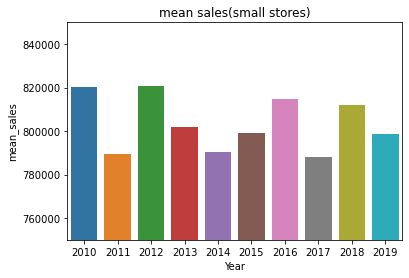

In [45]:
sns.barplot(data=results.loc[results['store_size'] == 'Small'], x='Year', y='mean_sales')
plt.ylim(750000, 850000)
plt.title("mean sales(small stores)")

Text(0.5, 1.0, 'mean sales(medium stores)')

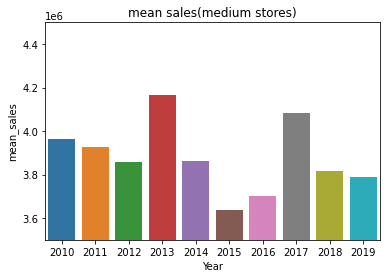

In [46]:
sns.barplot(data=results.loc[results['store_size'] == 'Medium'], x='Year', y='mean_sales')
plt.ylim(3500000, 4500000)
plt.title("mean sales(medium stores)")

Text(0.5, 1.0, 'mean sales(large stores)')

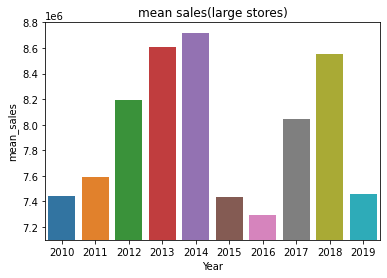

In [47]:
sns.barplot(data=results.loc[results['store_size'] == 'Large'], x='Year', y='mean_sales')
plt.ylim(7100000, 8800000)
plt.title("mean sales(large stores)")

### Soln-2- Reading a JSON file and displaying out a dictionary ###

In [48]:
# Defining a function to read the json file and display it in the for of a dictionary#

def ret_sls(filename):
    with open(filename, encoding='utf-8') as f:
        shop = json.load(f)
        tot_sales=0
        shop_det={}
        shop_det['Name']=shop['Name']
        shop_det['City']=shop['Address'].split(',')[0]
        shop_det['Postcode']=shop['Address'].split(',')[1]
        shop_det['Open_year']=shop['Opened']
        shop_det['Area']=shop['Area']
        if int(shop['Area'][0:-3])<1000:
            shop_det['Postcode']=shop['Address']
            shop_det['Store_Size']='Small'
        elif int(shop['Area'][0:-3])>4000:
            shop_det['Store_size']='Large'
        elif int(shop['Area'][0:-3])>1000 and int(shop['Area'][0:-3])<4000:
            shop_det['Store_size']='Medium'
        for i in shop['Sales']['Quarters']:
            tot_sales=tot_sales+(i[1])
        shop_det['Year']=shop['Sales']['Year']
        shop_det['Sales']= tot_sales
        return shop_det
    

In [49]:
# Testing the above function #
ret_sls('Oxford1Sales2019.json')

{'Name': 'Oxford1',
 'City': 'Oxford',
 'Postcode': ' OX5 1NS',
 'Open_year': 1990,
 'Area': '2750msq',
 'Store_size': 'Medium',
 'Year': 2019,
 'Sales': 3951000}

### Solution 3a(i)--- 10 stores in the small size category with the least sales ###

In [50]:
query2= '''select a.name,store_size,sum(sales)as Cumu from store_data a inner join sales_info b on a.name = b.name Where store_size='Small' and year in (2018,2019) group by a.name Order by Cumu LIMIT 10'''
cursor.execute(query2).fetchall()

[('London15', 'Small', 1447418),
 ('Birmingham7', 'Small', 1467575),
 ('London20', 'Small', 1487807),
 ('Birmingham11', 'Small', 1501104),
 ('Glasgow1', 'Small', 1508752),
 ('Bristol9', 'Small', 1508893),
 ('Birmingham20', 'Small', 1540796),
 ('Birmingham4', 'Small', 1543698),
 ('Manchester3', 'Small', 1545017),
 ('Birmingham2', 'Small', 1545086)]

In [51]:
least_sales=pd.read_sql_query(query2,conn) 
least_sales

,Name,store_size,Cumu
0,London15,Small,1447418
1,Birmingham7,Small,1467575
2,London20,Small,1487807
3,Birmingham11,Small,1501104
4,Glasgow1,Small,1508752
5,Bristol9,Small,1508893
6,Birmingham20,Small,1540796
7,Birmingham4,Small,1543698
8,Manchester3,Small,1545017
9,Birmingham2,Small,1545086


In [52]:
### Solution 3a-(ii)-Marketing spend for the above 10 stores

In [53]:
query3='''select f.name,f.store_size,sum(g.MarketingSpend) as Totmkt
from 
(select a.name,store_size,sum(sales) as Cumu
from store_data a
inner join 
sales_info b
on a.name = b.name
Where store_size='Small' and year in (2018,2019) 
group by a.name
Order by Cumu LIMIT 10)f
inner join
marketing_info g
on f.name=g.name
group by f.name,f.store_size
Order by Totmkt'''
cursor.execute(query3).fetchall()

[('London15', 'Small', 394432),
 ('Birmingham7', 'Small', 395962),
 ('Birmingham2', 'Small', 399508),
 ('Manchester3', 'Small', 401210),
 ('Birmingham20', 'Small', 401812),
 ('Birmingham11', 'Small', 403392),
 ('Bristol9', 'Small', 405241),
 ('London20', 'Small', 408281),
 ('Glasgow1', 'Small', 412373),
 ('Birmingham4', 'Small', 427698)]

In [54]:
# Total amount spent for each of the 10 stores#
sm_mkt= pd.read_sql_query(query3,conn)
sm_mkt

,name,store_size,Totmkt
0,London15,Small,394432
1,Birmingham7,Small,395962
2,Birmingham2,Small,399508
3,Manchester3,Small,401210
4,Birmingham20,Small,401812
5,Birmingham11,Small,403392
6,Bristol9,Small,405241
7,London20,Small,408281
8,Glasgow1,Small,412373
9,Birmingham4,Small,427698


In [55]:
query4= '''select f.name,f.store_size,g.year,g.MarketingSpend
from 
(select a.Name,store_size,sum(sales) as Cumu
from store_data a
inner join 
sales_info b
on a.name = b.name
Where store_size='Small' and year in (2018,2019) 
group by a.name
Order by Cumu LIMIT 10)f
inner join
marketing_info g
on f.name=g.name
Where year='2018-2019' '''
cursor.execute(query4).fetchall()

[('London15', 'Small', '2018-2019', 73149),
 ('Birmingham7', 'Small', '2018-2019', 79033),
 ('London20', 'Small', '2018-2019', 72799),
 ('Birmingham11', 'Small', '2018-2019', 86793),
 ('Glasgow1', 'Small', '2018-2019', 77572),
 ('Bristol9', 'Small', '2018-2019', 85743),
 ('Birmingham20', 'Small', '2018-2019', 82936),
 ('Birmingham4', 'Small', '2018-2019', 88297),
 ('Manchester3', 'Small', '2018-2019', 72430),
 ('Birmingham2', 'Small', '2018-2019', 84995)]

In [56]:
# Marketing spent for each of the 10 stores for 2018-2019#
mkt_l2= pd.read_sql_query(query4,conn)
mkt_l2

,Name,store_size,Year,MarketingSpend
0,London15,Small,2018-2019,73149
1,Birmingham7,Small,2018-2019,79033
2,London20,Small,2018-2019,72799
3,Birmingham11,Small,2018-2019,86793
4,Glasgow1,Small,2018-2019,77572
5,Bristol9,Small,2018-2019,85743
6,Birmingham20,Small,2018-2019,82936
7,Birmingham4,Small,2018-2019,88297
8,Manchester3,Small,2018-2019,72430
9,Birmingham2,Small,2018-2019,84995


In [57]:
query6= '''select f.store_size,g.year,sum(g.MarketingSpend) as TotMkt
from 
(select a.Name,store_size,sum(sales) as Cumu
from store_data a
inner join 
sales_info b
on a.name = b.name
Where store_size='Small' and year in (2018,2019) 
group by a.name
Order by Cumu LIMIT 10)f
inner join
marketing_info g
on f.name=g.name
Where year='2018-2019' '''
cursor.execute(query6).fetchall()

[('Small', '2018-2019', 803747)]

In [58]:
# The Total Marketing Spend for the above 10 stores in 2018-2019 is as follows#
mkt_tot= pd.read_sql_query(query6,conn)
mkt_tot

,store_size,Year,TotMkt
0,Small,2018-2019,803747


### Solution-3b- Predicting sales based on marketing expenditure ###

In [59]:
# Bringing together the data for sales and marketing for the stores in discussion for the years 2018-2019#
query5= '''select h.*,sum(sales) as Cum_sales
from
(select f.name,f.store_size,g.year,g.MarketingSpend
from 
(select a.name,store_size,sum(sales) as Cumu
from store_data a
inner join 
sales_info b
on a.name = b.name
Where store_size='Small' and year in (2018,2019) 
group by a.name
Order by Cumu LIMIT 10)f
inner join
marketing_info g
on f.name=g.name
Where year='2018-2019')h
inner join 
sales_info i
on h.name=i.name
Where store_size='Small' and i.year in (2018,2019) 
group by h.name,h.store_size,h.year,h.marketingspend'''
cursor.execute(query5).fetchall()

[('Birmingham11', 'Small', '2018-2019', 86793, 1501104),
 ('Birmingham2', 'Small', '2018-2019', 84995, 1545086),
 ('Birmingham20', 'Small', '2018-2019', 82936, 1540796),
 ('Birmingham4', 'Small', '2018-2019', 88297, 1543698),
 ('Birmingham7', 'Small', '2018-2019', 79033, 1467575),
 ('Bristol9', 'Small', '2018-2019', 85743, 1508893),
 ('Glasgow1', 'Small', '2018-2019', 77572, 1508752),
 ('London15', 'Small', '2018-2019', 73149, 1447418),
 ('London20', 'Small', '2018-2019', 72799, 1487807),
 ('Manchester3', 'Small', '2018-2019', 72430, 1545017)]

In [60]:
salmak= pd.read_sql_query(query5,conn)
salmak

,name,store_size,year,MarketingSpend,Cum_sales
0,Birmingham11,Small,2018-2019,86793,1501104
1,Birmingham2,Small,2018-2019,84995,1545086
2,Birmingham20,Small,2018-2019,82936,1540796
3,Birmingham4,Small,2018-2019,88297,1543698
4,Birmingham7,Small,2018-2019,79033,1467575
5,Bristol9,Small,2018-2019,85743,1508893
6,Glasgow1,Small,2018-2019,77572,1508752
7,London15,Small,2018-2019,73149,1447418
8,London20,Small,2018-2019,72799,1487807
9,Manchester3,Small,2018-2019,72430,1545017


In [61]:
mar_lst= salmak['MarketingSpend'].tolist()
sal_lst= salmak['Cum_sales'].tolist()

In [62]:
comp_df=copy.deepcopy(salmak)

In [63]:
def sales_pred(sales, market,sales_pred):
    ch_index=[]
    ch_sum=0
    index = list(range(len(sales)))  
    ratio = [v / w for v, w in zip(sales, market)]
    index.sort(key=lambda i: ratio[i], reverse=True)
    doub_i= round(len(sales)/2)
    ch_weights= copy.deepcopy(market)
    ch_sales=copy.deepcopy(sales)
    for i in range(0,doub_i):
        ch_weights[index[i]]= ch_weights[index[i]]*2
        ch_index.append(index[i])
        k=len(ch_index)
    while k>0 :
        for j in range(k-1,-1,-1):
            ch_sum=ch_sum+ch_weights[ch_index[j]]
            if ch_sum >=sum(market):
                ch_weights[ch_index[k-1]]=(ch_weights[ch_index[k-1]]/2)
                k=k-1
                ch_sum=0
                break
            elif ch_sum<sum(market) and j==0:
                k=0
                

    if sum(market)>sum(ch_weights):
        diff1= sum(market)-sum(ch_weights)
        for m in range(len(ch_index),len(index)):
            for n in (1,0.75,0.5,0.33,0.25):
                if ch_weights[index[m]]+(diff1*n) <= 2* market[index[m]]:
                    ch_weights[index[m]]=ch_weights[index[m]]+(diff1*n)
                    diff1=diff1-diff1*n
                    continue
        if diff1!=0:
            for o in range(0,len(index)):
                if ch_weights[index[o]] <= 2* market[index[o]] and diff1>0:
                    canadd=2*market[index[o]]-ch_weights[index[o]]
                    if diff1>canadd:
                        ch_weights[index[o]]=ch_weights[index[o]]+ canadd
                        diff1=diff1-canadd
                    else:
                        ch_weights[index[o]]=ch_weights[index[o]]+diff1
                        diff1=diff1-diff1  
                    continue  
        



    else:
        diff2= sum(ch_weights)-sum(market)
        for m in range(len(index)-1,len(ch_index)-1,-1):
            for n in (1,0.75,0.5,0.33,0.25):
                if ch_weights[index[m]]-(diff2*n) >= 0.5* market[index[m]]:
                    ch_weights[index[m]]=ch_weights[index[m]]-(diff2*n)
                    diff2=diff2-diff2*n
                    continue
        if diff2!=0:
            for o in range(len(index)-1,-1,-1):
                if ch_weights[index[o]] >= 0.5* market[index[o]] and diff2>0:
                    deficit=ch_weights[index[o]]-0.5*market[index[o]]
                    if diff2>deficit:
                        ch_weights[index[o]]=ch_weights[index[o]]-deficit
                        diff2=diff2-deficit
                    else:
                        ch_weights[index[o]]=ch_weights[index[o]]-diff2
                        diff2=diff2-diff2  
                    continue  
                    
    
    for eq in range(0,len(ch_weights)):
        if ch_weights[eq]>market[eq]:
            ch_sales[eq]= ch_sales[eq]*(ch_weights[eq]/market[eq])
        else:
            ch_sales[eq]= ch_sales[eq]/(market[eq]/ch_weights[eq]) 
    
    comp_df['Pred_Sales']= ch_sales
    comp_df['Pred_marketing']= ch_weights
    comp_df['Pred_Sales']=comp_df['Pred_Sales'].apply(lambda x: '%.3f' % x)
    comp_df['Pred_Sales']=comp_df['Pred_Sales'].apply(lambda x:float(x))
    comp_df['Pred_marketing']=comp_df['Pred_marketing'].apply(lambda x: '%.3f' % x)
    comp_df['Pred_marketing']=comp_df['Pred_marketing'].apply(lambda x:float(x))
    return comp_df

In [64]:
final_pred=sales_pred(sal_lst,mar_lst,comp_df)
final_pred

,name,store_size,year,MarketingSpend,Cum_sales,Pred_Sales,Pred_marketing
0,Birmingham11,Small,2018-2019,86793,1501104,750552.00,43396.5
1,Birmingham2,Small,2018-2019,84995,1545086,772543.00,42497.5
2,Birmingham20,Small,2018-2019,82936,1540796,770398.00,41468.0
3,Birmingham4,Small,2018-2019,88297,1543698,771849.00,44148.5
4,Birmingham7,Small,2018-2019,79033,1467575,733787.50,39516.5
5,Bristol9,Small,2018-2019,85743,1508893,754446.50,42871.5
6,Glasgow1,Small,2018-2019,77572,1508752,2199615.01,113092.5
7,London15,Small,2018-2019,73149,1447418,2894836.00,146298.0
8,London20,Small,2018-2019,72799,1487807,2975614.00,145598.0
9,Manchester3,Small,2018-2019,72430,1545017,3090034.00,144860.0


In [65]:
print("Sales in 2018-2019 was: "+str(final_pred['Cum_sales'].sum())+"\nMarketing Cost in 2018-2019 was: "+str(final_pred['MarketingSpend'].sum())+ "\nSales in 2020-2021 is predicted to be: "+str(final_pred['Pred_Sales'].sum())+ "\nMarketing in 2020-2021 is same as before,which is: "+str(final_pred['Pred_marketing'].sum())+"\nThe sales in 2020-2021 are predicted to rise by: "+str(final_pred['Pred_Sales'].sum()-final_pred['Cum_sales'].sum()))

Sales in 2018-2019 was: 15096146
Marketing Cost in 2018-2019 was: 803747
Sales in 2020-2021 is predicted to be: 15713675.01
Marketing in 2020-2021 is same as before,which is: 803747.0
The sales in 2020-2021 are predicted to rise by: 617529.0099999998


In [66]:
conn.close()